# 💳 Task 2 – EDA & Behavioral Risk Exploration  
📘 Version: 2025-07-01

Structured exploratory data analysis (EDA) and risk signal discovery for **Bati Bank’s BNPL Credit Scoring Initiative**. This notebook analyzes behavioral transaction data from an eCommerce platform to uncover patterns in spending frequency, transaction value, platform usage, and product category preferences. Outputs from this task will inform proxy label engineering (Task 4) and model development (Task 5).

---

**Challenge:** B5W5 – Credit Scoring & Risk Modeling  
**Company:** Bati Bank (in partnership with an eCommerce platform)  
**Author:** Nabil Mohamed  
**Branch:** `task-2-exploratory-analysis`  
**Date:** July 2025  

---

### 📌 This notebook covers:
- Importing and profiling raw transactional data (`transactions.csv`)
- Assessing data structure, formats, and null values
- Distribution analysis of transaction value and volume
- Behavioral variation across products, channels, and user segments
- Temporal trend analysis of transaction frequency and monetary value
- Outlier detection and fraud pattern review
- Initial hypotheses for proxy risk label definition and model feature design

In [1]:
# ------------------------------------------------------------------------------
# 🛠 Ensure Notebook Runs from Project Root (for src/ imports to work)
# ------------------------------------------------------------------------------

import os
import sys

# If running from /notebooks/, move up to project root
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    print("📂 Changed working directory to project root")

# Add project root to sys.path so `src/` modules can be imported
project_root = os.getcwd()
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"✅ Added to sys.path: {project_root}")

# Optional: verify file presence to confirm we're in the right place
expected_path = "data/raw"
print(
    "📁 Output path ready"
    if os.path.exists(expected_path)
    else f"⚠️ Output path not found: {expected_path}"
)

📂 Changed working directory to project root
✅ Added to sys.path: c:\Users\admin\Documents\GIT Repositories\b5w5-credit-scoring-challenge
📁 Output path ready


## 📦 Imports & Environment Setup

This cell loads the core libraries required for behavioral analysis, data profiling, and visualization in the context of credit risk modeling. Imports are grouped by function:

- **Data handling:** `pandas`, `numpy`
- **Visualization:** `matplotlib`, `seaborn`
- **Date/time analysis:** `datetime`, `pandas.to_datetime`
- **System & utilities:** `os`, `warnings`, `pathlib`


In [2]:
# ---------------------------
# 📦 Imports & Environment Setup
# ---------------------------

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Date/time analysis
from datetime import datetime
from pandas.api.types import CategoricalDtype

# System & utilities
import os
import warnings
from pathlib import Path

# Configure display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:,.2f}".format)
warnings.filterwarnings("ignore")

# Set seaborn style
sns.set(style="whitegrid", context="notebook")

## 📥 Load & Preview Raw Transaction Dataset (Task 2 EDA)

This step loads the eCommerce transaction dataset (`data.csv`) containing customer-level purchase behavior used to engineer credit risk features.

- Reads the raw file from `data/raw/data.csv` using the `pandas` library
- Verifies data structure (row/column count, column integrity, data types)
- Outputs diagnostics: shape, column summary, and preview sample
- Raises explicit errors if the file is missing or malformed
- Designed for robustness, reusability, and downstream processing compatibility

This ensures the raw dataset is correctly staged for exploratory analysis and proxy risk label engineering in later tasks.


In [3]:
# ------------------------------------------------------------------------------
# 📦 Load Raw Credit Transaction Data (Production-Grade Loader)
# ------------------------------------------------------------------------------

from src.data_loader import CreditDataLoader  # Custom safe loader for B5W5

# Define path to raw data file (CSV format)
data_path = "data/raw/data.csv"

# Initialize the loader class
loader = CreditDataLoader(filepath=data_path)

# Load DataFrame with defensive error handling
try:
    df = loader.load()
except Exception as e:
    print(f"❌ Failed to load transaction data: {e}")

✅ Transaction dataset loaded: 95,662 rows × 16 columns


## 🧾 Layer 1 – Foundational Schema Audit (Structure, Nulls, Uniqueness)

This foundational step validates the structural integrity of the transaction dataset.

- 📏 Logs dataset shape (rows × columns) and column types
- 🔍 Summarizes missing values, constant columns, and high-cardinality fields
- 🧼 Flags uninformative columns (e.g., constant values or overly unique identifiers)
- ⚠️ Highlights potential data quality risks before modeling
- 📊 Returns a diagnostic schema summary dictionary for audit and cleaning

This ensures the data is structurally sound before applying any behavioral or statistical modeling logic.


In [4]:
# ------------------------------------------------------------------------------
# 🧾 Layer 1 – Foundational Schema Audit (Refactored, Defensive)
# ------------------------------------------------------------------------------

# ✅ Import the defensive schema auditor
from src.eda.schema_auditor import SchemaAuditor

# ✅ Step 1: Initialize auditor with loaded transaction DataFrame
auditor = SchemaAuditor(df)

# ✅ Step 2: Run schema audit and capture report
schema_report = auditor.report()

# ✅ Step 3: Display top-level diagnostics
print("📦 Dataset Overview")
print(f"→ Rows:     {schema_report['shape'][0]:,}")
print(f"→ Columns:  {schema_report['shape'][1]}")

print("\n🧊 Constant Columns:")
print(schema_report["constant_columns"] or "✅ None")

print("\n🔢 High-Cardinality Columns (90%+ unique):")
print(schema_report["high_cardinality"] or "✅ None")

print("\n📉 Null Counts:")
for col, count in schema_report["null_counts"].items():
    if count > 0:
        print(f"• {col}: {count:,} missing values")

print("\n🔍 Data Types:")
for col, dtype in schema_report["dtypes"].items():
    print(f"• {col}: {dtype}")

✅ Schema audit complete: 16 columns analyzed.
📦 Dataset Overview
→ Rows:     95,662
→ Columns:  16

🧊 Constant Columns:
['CurrencyCode', 'CountryCode']

🔢 High-Cardinality Columns (90%+ unique):
['TransactionId', 'BatchId', 'TransactionStartTime']

📉 Null Counts:

🔍 Data Types:
• TransactionId: object
• BatchId: object
• AccountId: object
• SubscriptionId: object
• CustomerId: object
• CurrencyCode: object
• CountryCode: int64
• ProviderId: object
• ProductId: object
• ProductCategory: object
• ChannelId: object
• Amount: float64
• Value: int64
• TransactionStartTime: object
• PricingStrategy: int64
• FraudResult: int64


## 💰 Layer 2 – Monetary Value Distributions (Amount vs Value)

This layer explores how monetary variables behave in the transaction dataset.

- 📏 `Amount`: Signed transaction flow (positive = debit, negative = credit/refund)
- 💵 `Value`: Absolute transaction magnitude (always positive)
- 📊 Histogram + KDE to assess distribution shape, skew, and granularity
- 🔎 Boxplot to surface extreme values and outliers
- ⚠️ Log-scale overlay for long-tailed or exponential patterns

This step is crucial for spotting refund patterns, payment anomalies, and segment-specific monetary behavior before feature engineering.


📊 Distribution of 'Amount' (Signed Flow)


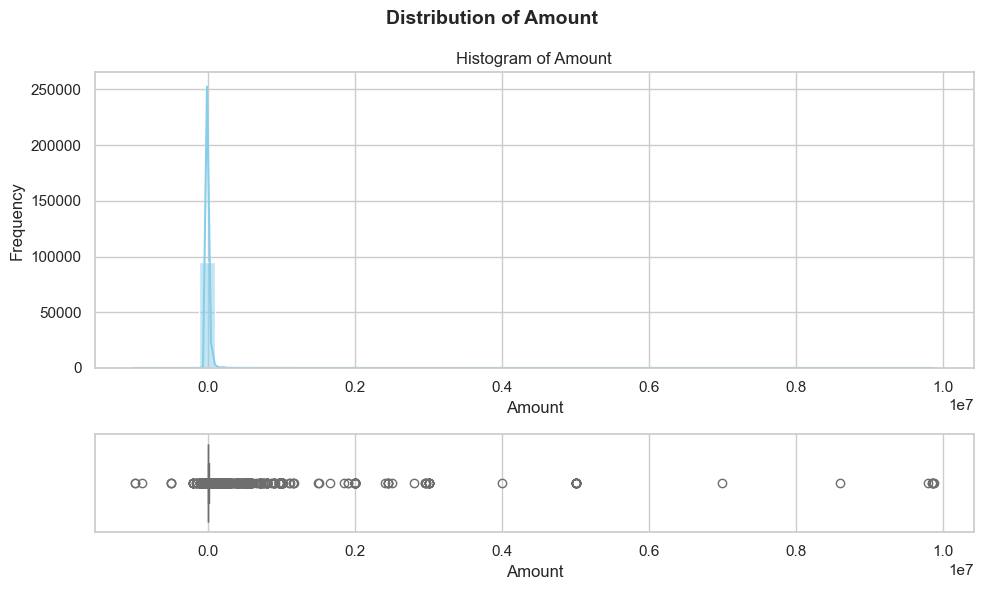

📊 Distribution of 'Value' (Magnitude, Log Scaled)


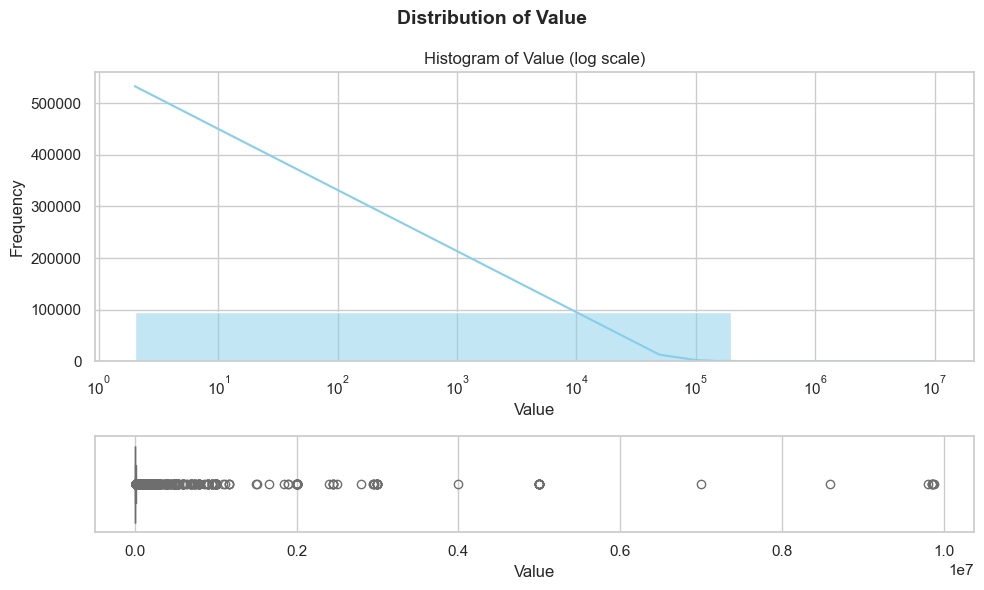

In [5]:
# ------------------------------------------------------------------------------
# 💰 Layer 2 – Monetary Value Distributions (Visualized)
# ------------------------------------------------------------------------------

# ✅ Import the univariate distribution analyzer
from src.eda.distribution_analyzer import DistributionAnalyzer

# ✅ Step 1: Initialize the analyzer with transaction DataFrame
dist_viz = DistributionAnalyzer(df)

# ✅ Step 2: Plot distribution of signed transaction amounts
print("📊 Distribution of 'Amount' (Signed Flow)")
dist_viz.plot_numeric("Amount")

# ✅ Step 3: Plot distribution of value magnitude (unsigned)
print("📊 Distribution of 'Value' (Magnitude, Log Scaled)")
dist_viz.plot_numeric("Value", log_scale=True)

## 🧮 Layer 3 – Categorical Feature Analysis (Channels, Products, Providers)

This layer explores key categorical variables to understand customer interaction patterns across channels, products, and merchant providers.

- 🛍 `ProductCategory`: What types of goods dominate?
- 🌐 `ChannelId`: Are users transacting via web, mobile, or Pay Later?
- 🏢 `ProviderId`: Which merchant platforms are most active?
- ⚙️ `PricingStrategy`, `CurrencyCode`: Ancillary features with potential signal

The goal is to surface dominant classes, understand class imbalance, and identify categories potentially linked to fraud or disengagement.


🛍 Top Product Categories


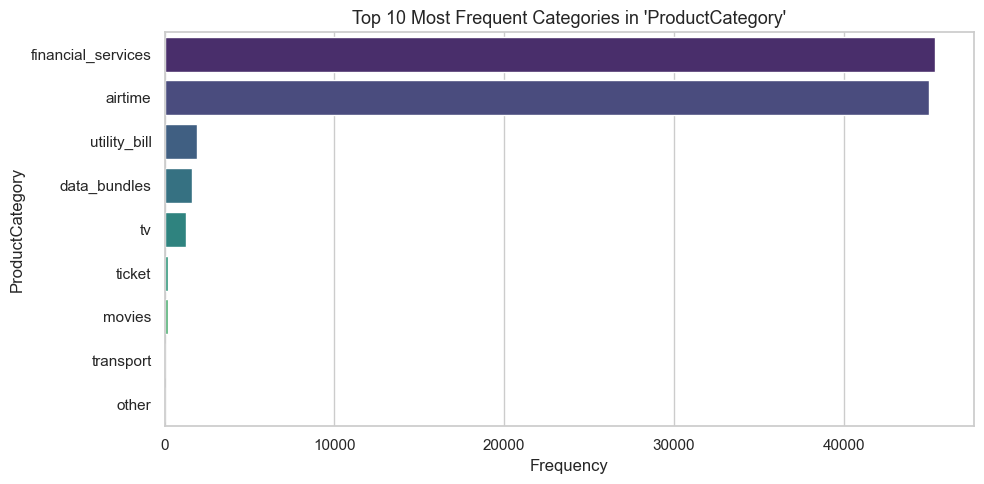

🌐 Transaction Channels (ChannelId)


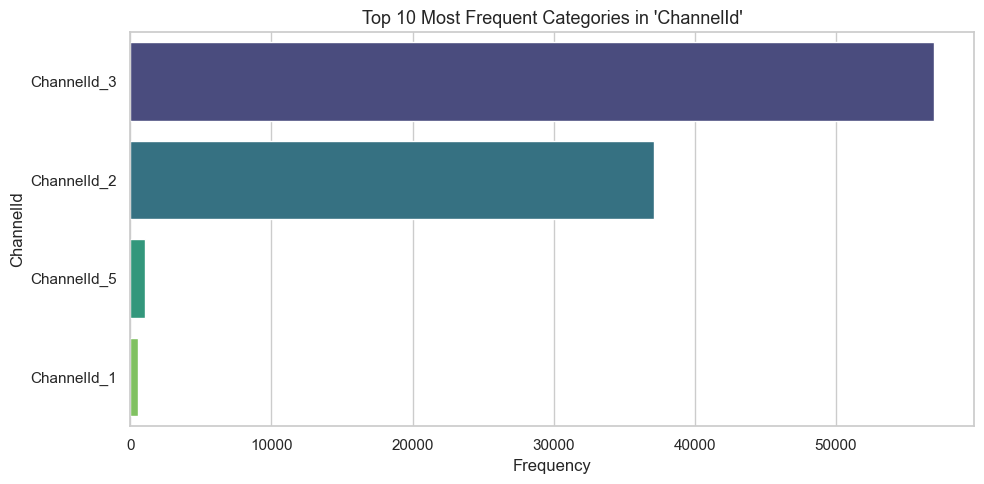

🏢 Most Active Providers


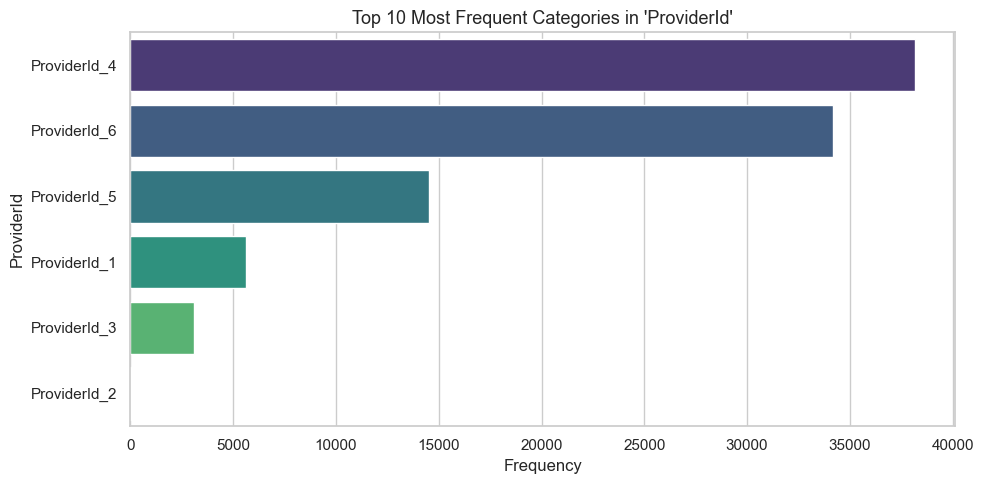

⚙️ Pricing Strategy Distribution


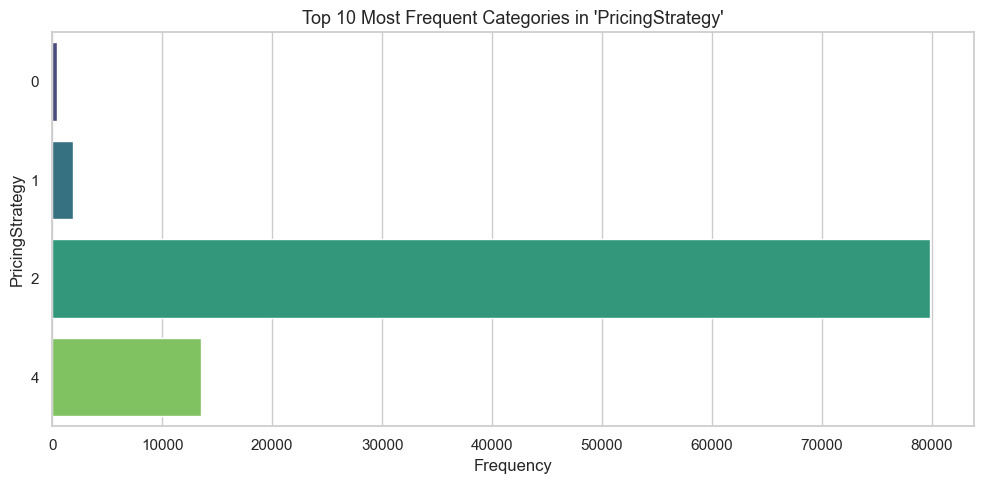

💱 Currency Codes


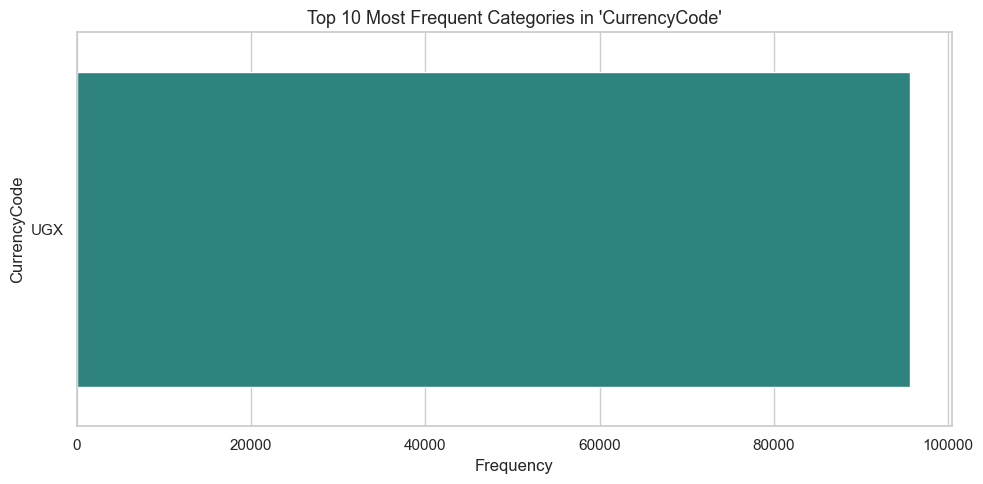

In [10]:
# ------------------------------------------------------------------------------
# 🧮 Layer 3 – Categorical Feature Distributions (Top-K Frequency)
# ------------------------------------------------------------------------------

# ✅ Reuse the distribution analyzer instance
# If reloading notebook from scratch, uncomment:
# from src.eda.distribution_analyzer import DistributionAnalyzer
# dist_viz = DistributionAnalyzer(df)

# ✅ Step 1: Visualize Product Category spread
print("🛍 Top Product Categories")
dist_viz.plot_categorical("ProductCategory", top_k=10)

# ✅ Step 2: Visualize transaction channel preference
print("🌐 Transaction Channels (ChannelId)")
dist_viz.plot_categorical("ChannelId", top_k=10)

# ✅ Step 3: Visualize dominant providers (e.g., merchants or platforms)
print("🏢 Most Active Providers")
dist_viz.plot_categorical("ProviderId", top_k=10)

# ✅ Step 4 (Optional): Pricing strategy breakdown
# 🧼 Defensive type fix – ensure PricingStrategy is treated as categorical
if "PricingStrategy" in df.columns:
    df["PricingStrategy"] = df["PricingStrategy"].astype("category")
    dist_viz.df["PricingStrategy"] = df["PricingStrategy"]  # Sync update inside class

print("⚙️ Pricing Strategy Distribution")
dist_viz.plot_categorical("PricingStrategy", top_k=10)

# ✅ Step 5 (Optional): CurrencyCode check (should likely be 1–2 max)
print("💱 Currency Codes")
dist_viz.plot_categorical("CurrencyCode", top_k=10)

## ⏰ Layer 4 – Temporal Patterns in User Activity

This layer explores the time-based structure of transactions, identifying behavioral patterns by hour, weekday, and monthly trends.

- 🧭 Converts `TransactionStartTime` to datetime
- 🕒 Visualizes transaction peaks by hour of day
- 📆 Reveals weekday vs weekend usage patterns
- 📈 Plots overall activity volume by month
- 🧠 Supports temporal segment modeling (recency, time clusters)

These insights can inform downstream proxy labels, customer segmentation, or early risk scoring based on transaction timing.


🕒 Hourly Transaction Volume


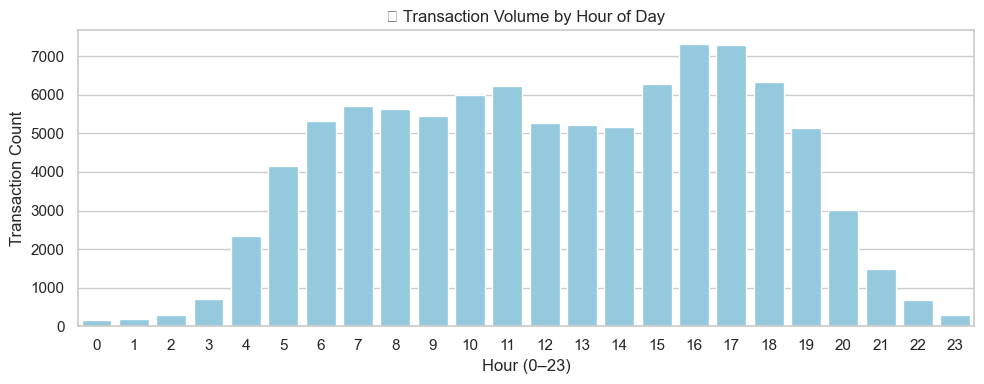

📆 Daily Transaction Volume


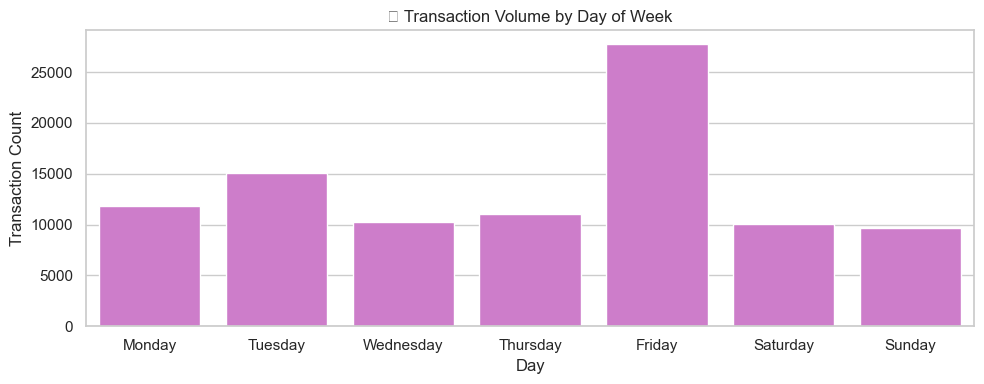

📈 Monthly Transaction Trend


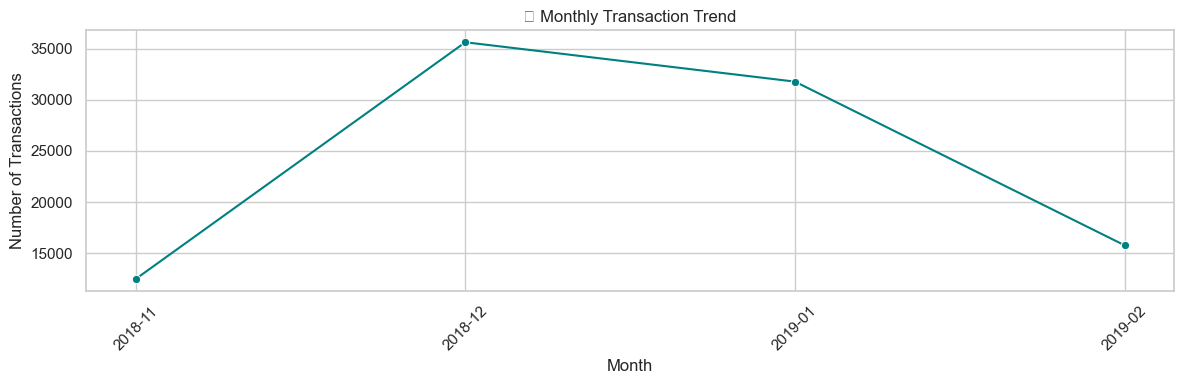

In [7]:
# ------------------------------------------------------------------------------
# ⏰ Layer 4 – Temporal Behavior Analysis (Hour, Day, Month)
# ------------------------------------------------------------------------------

# ✅ Import temporal analyzer (if not already loaded)
from src.eda.temporal_behavior_analyzer import TemporalBehaviorAnalyzer

# ✅ Initialize analyzer with timestamp column
time_analyzer = TemporalBehaviorAnalyzer(df, datetime_col="TransactionStartTime")

# ✅ Step 1: Hour-of-day pattern
print("🕒 Hourly Transaction Volume")
time_analyzer.plot_transactions_by_hour()

# ✅ Step 2: Day-of-week pattern
print("📆 Daily Transaction Volume")
time_analyzer.plot_transactions_by_dayofweek()

# ✅ Step 3: Monthly activity trend
print("📈 Monthly Transaction Trend")
time_analyzer.plot_monthly_trend()

## 🧑‍💼 Layer 5 – Customer Behavior Profiling (Mini-RFM Summary)

This layer derives customer-level behavioral insights using the Recency–Frequency–Monetary (RFM) model.

- 🔁 Frequency = total transactions per customer
- 💰 Monetary = total value transacted
- ⏱ Recency = days since last activity from snapshot (2024-01-01)

These behavioral metrics form the backbone for segmentation and proxy creditworthiness in downstream modeling.

- 🧠 Useful for proxy target design in Task 4
- ⚠️ Early outlier detection on inactive, low-frequency, or high-volume users


In [8]:
# ------------------------------------------------------------------------------
# 🧑‍💼 Layer 5 – Customer Behavior Profiling via RFM Summary
# ------------------------------------------------------------------------------

# ✅ Import the RFM profiler
from src.eda.customer_behavior_analyzer import CustomerBehaviorProfiler

# ✅ Step 1: Initialize profiler with relevant columns
rfm_profiler = CustomerBehaviorProfiler(
    df=df,
    customer_id_col="CustomerId",
    date_col="TransactionStartTime",
    value_col="Value",
)

# ✅ Step 2: Define snapshot reference for Recency computation
snapshot = "2024-01-01"

# ✅ Step 3: Compute RFM metrics
rfm_df = rfm_profiler.compute_rfm(snapshot_date=snapshot)

# ✅ Step 4: Display a sample of the RFM table
display(rfm_df.head())

✅ RFM profile computed for 3,742 customers (Snapshot: 2024-01-01)


,CustomerId,Recency,Frequency,Monetary
0,CustomerId_1,1866,1,10000
1,CustomerId_10,1866,1,10000
2,CustomerId_1001,1871,5,30400
3,CustomerId_1002,1808,11,4775
4,CustomerId_1003,1794,6,32000


## 🛡 Layer 6 – Fraud Segment Analysis

This layer inspects the distribution of fraud outcomes across key categorical dimensions.

- 📌 `FraudResult` is treated as a binary flag (0 = not fraud, 1 = fraud)
- 📊 Fraud frequency and rate are computed per segment
- 🔍 Identifies high-risk channels, products, or behaviors
- 📈 Plots relative fraud rates using horizontal bar charts

Used to detect potential risk-prone segments that can inform proxy label creation in Task 4 or model features.


✅ Fraud summary computed by 'ProductCategory'


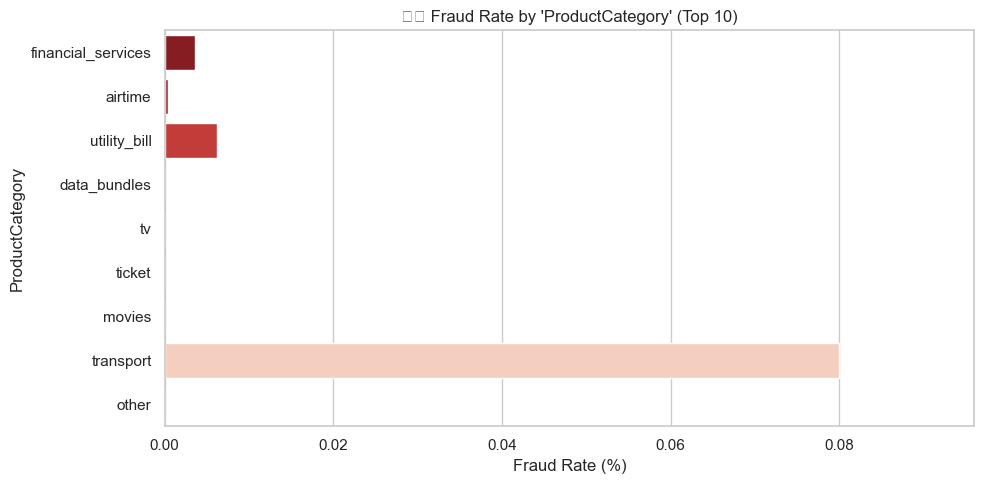

✅ Fraud summary computed by 'ChannelId'


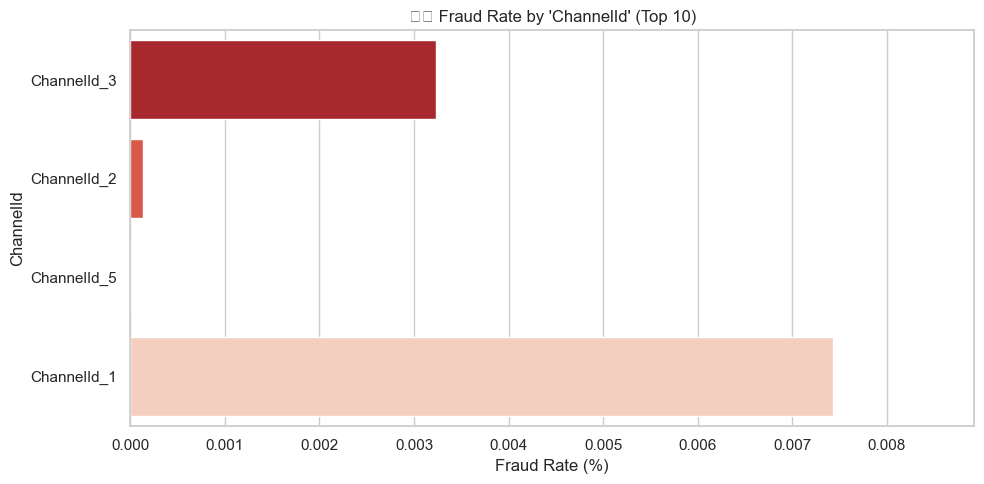

✅ Fraud summary computed by 'ProviderId'


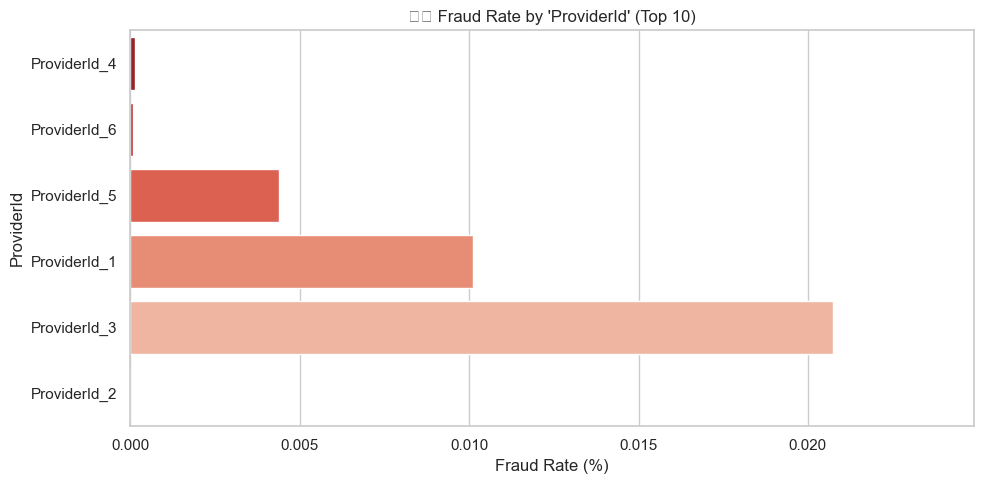

In [ ]:
# ------------------------------------------------------------------------------
# 🛡 Layer 6 – Fraud Segment Analysis
# ------------------------------------------------------------------------------

# ✅ Import the fraud segment analyzer
from src.eda.fraud_segment_analyzer import FraudSegmentAnalyzer

# ✅ Step 1: Initialize the analyzer
fraud_analyzer = FraudSegmentAnalyzer(df=df, fraud_col="FraudResult")

# ✅ Step 2: List candidate segment columns
segment_candidates = ["ProductCategory", "ChannelId", "ProviderId"]

# ✅ Step 3: Loop through each segment and plot fraud risk
for col in segment_candidates:
    try:
        fraud_analyzer.plot_fraud_rate_by_segment(segment_col=col, top_k=10)
    except Exception as e:
        print(f"⚠️ Skipped '{col}' due to error: {e}")